In [135]:
import requests
from datetime import timezone, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [55]:
# we want to get a day's worth of BTC data from coingecko at a specified interval

CURRENCY = 'btc'

# use pre-acquired coin id data
ids = pd.read_csv("cg_coin_ids.csv")
coin_id = ids[ids['symbol'] == CURRENCY]['id'].values[0]

res = requests.get(f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=usd&days=1')
res.raise_for_status()

coin_data = res.json()
unzipped = list(zip(*coin_data['prices']))
prices_raw = pd.DataFrame({'ms_datetime': unzipped[0], 'price': unzipped[1]})

In [149]:
# format dataset time
prices_raw['date_time'] = pd.to_datetime(prices_raw['ms_datetime'], unit='ms', utc=True)
prices = prices_raw[['date_time', 'price']].copy()
prices['local_dt'] = prices['date_time'].dt.tz_convert(timezone(-timedelta(hours=6)))
prices = prices.sort_values(by='local_dt')[['local_dt', 'price']]

# cut down to 15-minute intervals
prices['fifteen_min'] = np.tile(range(1, 4), prices.shape[0]//3 + 1)[:prices.shape[0]]
prices['fifteen_min'] = prices['fifteen_min'] == 1
m15 = prices[prices['fifteen_min']].reset_index(drop=True)
m15 = m15[['local_dt', 'price']]

# add moving average
ma_period = 4
m15['ma'] = m15['price'].rolling(ma_period).mean()

# add rsi
periods = 14
m15['price_change'] = m15['price'].diff()
m15['pos_pc'] = m15['price_change'].apply(lambda x: x if x > 0 else 0)
m15['neg_pc'] = m15['price_change'].apply(lambda x: abs(x) if x < 0 else 0)

m15['avg_gain'] = m15['pos_pc'].rolling(periods).mean()
m15['avg_loss'] = m15['neg_pc'].rolling(periods).mean()
m15['rs'] = m15['avg_gain'] / m15['avg_loss']
m15['rsi'] = 100 - (100 / (1 + m15['rs']))
m15

,local_dt,price,ma,price_change,pos_pc,neg_pc,avg_gain,avg_loss,rs,rsi
0,2023-03-15 20:14:58.321000-06:00,24555.857027,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,2023-03-15 20:30:11.358000-06:00,24588.347712,NaN,32.490685,32.490685,0.000000,NaN,NaN,NaN,NaN
2,2023-03-15 20:45:28.120000-06:00,24554.661674,NaN,-33.686038,0.000000,33.686038,NaN,NaN,NaN,NaN
3,2023-03-15 21:00:08.215000-06:00,24516.218551,24553.771241,-38.443123,0.000000,38.443123,NaN,NaN,NaN,NaN
4,2023-03-15 21:15:10.707000-06:00,24456.578519,24528.951614,-59.640032,0.000000,59.640032,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
92,2023-03-16 19:15:25.888000-06:00,25120.879945,25098.210079,37.526762,37.526762,0.000000,23.641058,15.315874,1.543566,60.685112
93,2023-03-16 19:30:40.923000-06:00,25264.085416,25136.956418,143.205471,143.205471,0.000000,26.785462,15.315874,1.748869,63.621406
94,2023-03-16 19:45:38.194000-06:00,25614.170198,25270.622186,350.084781,350.084781,0.000000,51.791518,13.238023,3.912330,79.643062
95,2023-03-16 19:59:45.888000-06:00,25741.588200,25435.180940,127.418003,127.418003,0.000000,60.892804,12.475893,4.880837,82.995619


Text(0.5, 0, 'Date/Time')

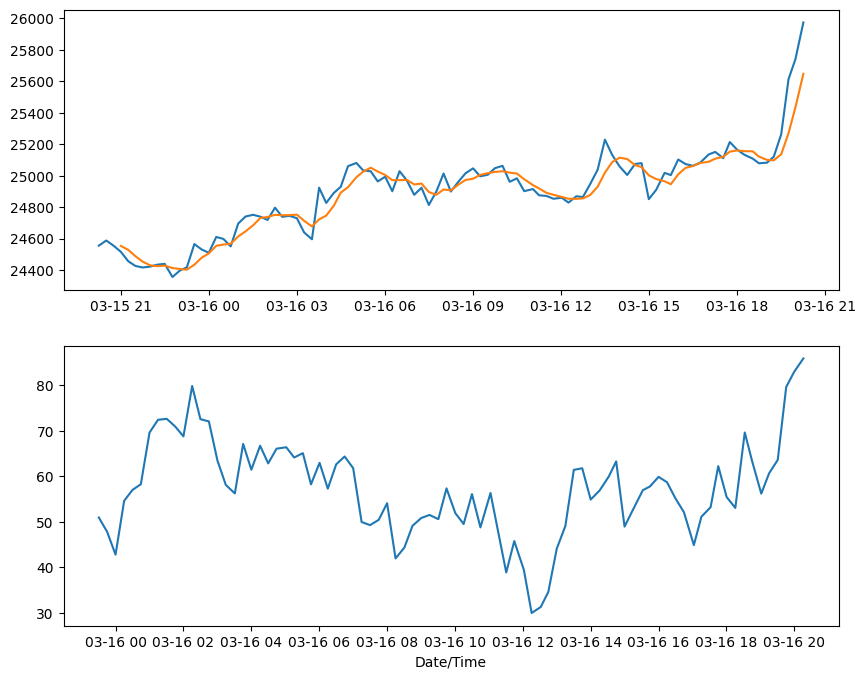

In [152]:
# plot price, moving average and rsi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))


ax1.plot(m15['local_dt'], m15['price'])
ax1.plot(m15['local_dt'], m15['ma'])

ax2.plot(m15['local_dt'], m15['rsi'])
ax2.set_xlabel('Date/Time')